# Experiment regarding the line finder framework

In [9]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
from src.data.dataset_line_finder import DatasetLineFinder
from src.segmentation.gcn_model import GCN

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [318]:
parameters = {"segmentation_weights": os.path.join('..', 'trained_moels', 'segmentation', 'GCN_512_cBAD.pt'), 
              "input_folder": '..\\data\\cBAD-ICDAR2019', 
              "max_side": 512, 
              "crop_size": 512}
ds = DatasetLineFinder(inf_type='train', 
                       parameters=parameters, 
                       device='cpu', 
                       seg_model_weights=os.path.join('..', 'trained_models', 'segmentation', 'GCN_512_cBAD.pt'))

## Plot label

In [319]:
n = 3

In [320]:
data = ds[n]

img = data['image'].numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)

ll = data['label_len']
sp = data['label'][:ll, 0:2]
angles = data['label'][:ll, 2]
box_size = 32

#plt.imshow(img)

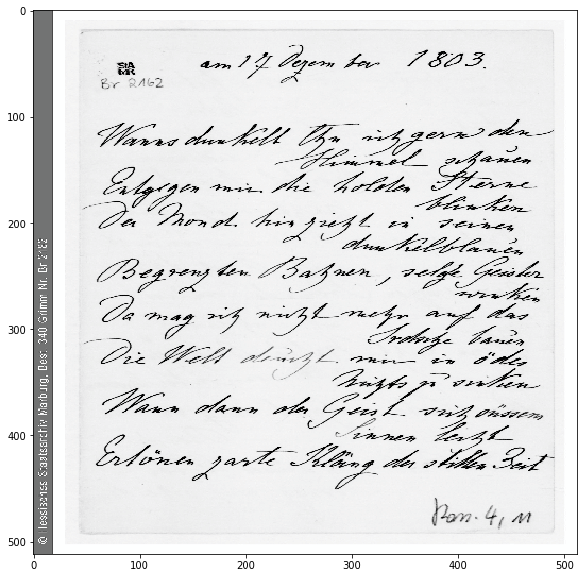

In [321]:
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,:])

In [322]:
labels = np.zeros(img.shape)

for k, s in enumerate(sp):
    x = int(s[0].item())
    y = int(s[1].item())
    cv2.circle(labels, (x, y), box_size, (1.0,0,0), 4)
    cv2.line(labels, (x,y), (x + 2*box_size*np.cos(angles[k]), y - 2*box_size*np.sin(angles[k])), (0, 1.0, 0), 4)
    
    
#plt.imshow(labels)

Some plots that show what the dataset ouputs

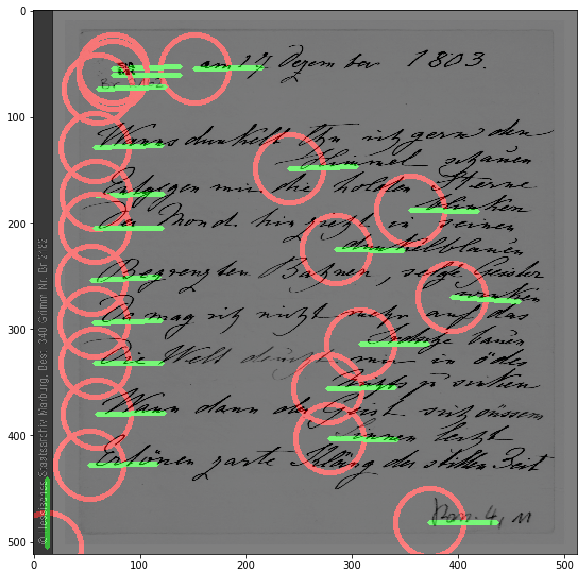

In [323]:
combined = cv2.addWeighted(img, 0.5, labels, 0.5, 0)

plt.figure(figsize=(20,10))
plt.imshow(combined)

# Segmentation output

In [324]:
segmentation_weights = os.path.join('..', 'trained_models', 'segmentation', 'GCN_512_cBAD.pt')
segmentation_device = 'cpu'

In [325]:
print('## Loading segmentation model')
seg_model = GCN(n_classes=4)
seg_model.load_state_dict(torch.load(segmentation_weights, map_location=segmentation_device))
seg_model.to(segmentation_device)
seg_model.eval()
print('## Loaded!')

## Loading segmentation model
## Loaded!


In [327]:
image = data['image'].unsqueeze(0)
with torch.no_grad():
    seg_out = seg_model(image)[0]
    seg_out.detach()
    
    sig = nn.Sigmoid()
    seg_out = sig(seg_out)
image = (image[:, 0:1, :, :] + image[:, 1:2, :, :] + image[:, 2:3, :, :])/3.0
image = torch.cat([image, seg_out[:, [0, 2], :, :]], dim=1).detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


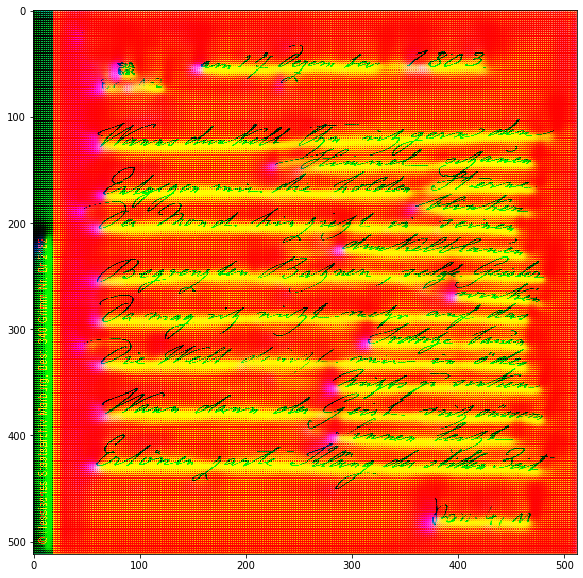

In [328]:
plt.figure(figsize=(20,10))
image_np = image[0].permute(1,2,0).detach().numpy()
plt.imshow(image_np)

## Plot model output

In [330]:
model_ft = torch.load(os.path.join('..', 'trained_models', 'line_finder', 'line_finder_default.pt'), map_location=torch.device('cpu'))
model_ft.device = torch.device('cpu')

FileNotFoundError: [Errno 2] No such file or directory: '..\\trained_models\\line_finder\\line_finder_default_old.pt'

In [9]:
n = 3

out = model_ft(data['image'].unsqueeze(0))

print('## out shape: ' + str(out.shape))
print('## sp shape: ' + str(sp.shape))

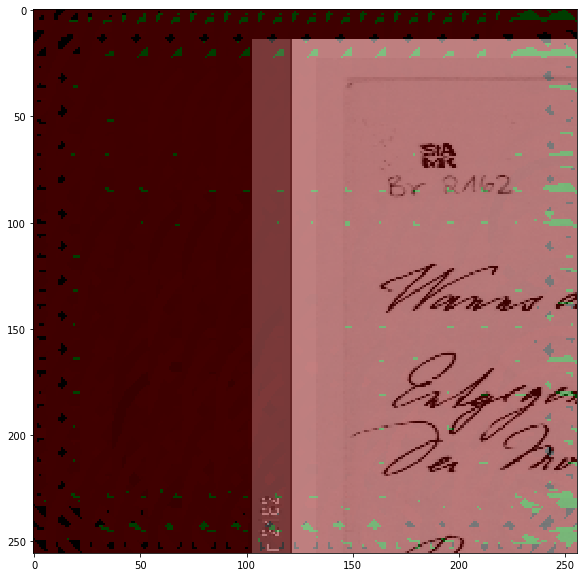

In [13]:
img = data['image'].numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)


sp = out[0, :, 0:2].detach()
angles = out[0, :, 2].detach()
confidence = out[0, :, 3].detach()
box_size = 32

labels = np.zeros(img.shape)

for k, s in enumerate(sp):
    if confidence[k] < -0.1:
        continue
    else:
        ccolor = 1.0*confidence[k].item()
        x = int(s[0].item())
        y = int(s[1].item())
        cv2.circle(labels, (x, y), box_size, (ccolor,0,0), 4)
        cv2.line(labels, (x,y), (x + 2*box_size*np.cos(angles[k]), y - 2*box_size*np.sin(angles[k])), (0, ccolor, 0), 4)
    
combined = cv2.addWeighted(img, 0.5, labels, 0.5, 0)

plt.figure(figsize=(20,10))
plt.imshow(combined)

# __Seg experiments__

In [331]:
import cv2
import torch.nn as nn

In [332]:
probs = seg_out[0, 0:3, :, :].permute(1,2,0).detach().numpy()

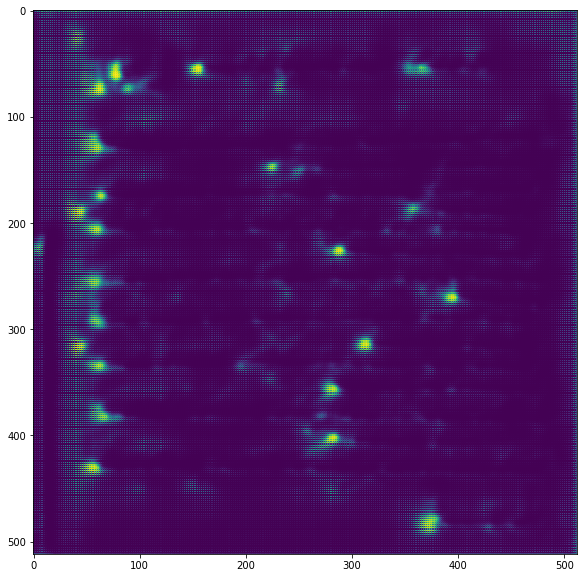

In [371]:
plt.figure(figsize=(20,10))
plt.imshow(image_np[:,:,2])

In [369]:
cv2.imwrite('pout.jpg', probs[:,:,2]*255.0)

True

In [354]:
shrink = cv2.morphologyEx(probs, cv2.MORPH_OPEN, (5,5))

In [363]:
shrink = cv2.morphologyEx(shrink, cv2.MORPH_OPEN, (2,2))

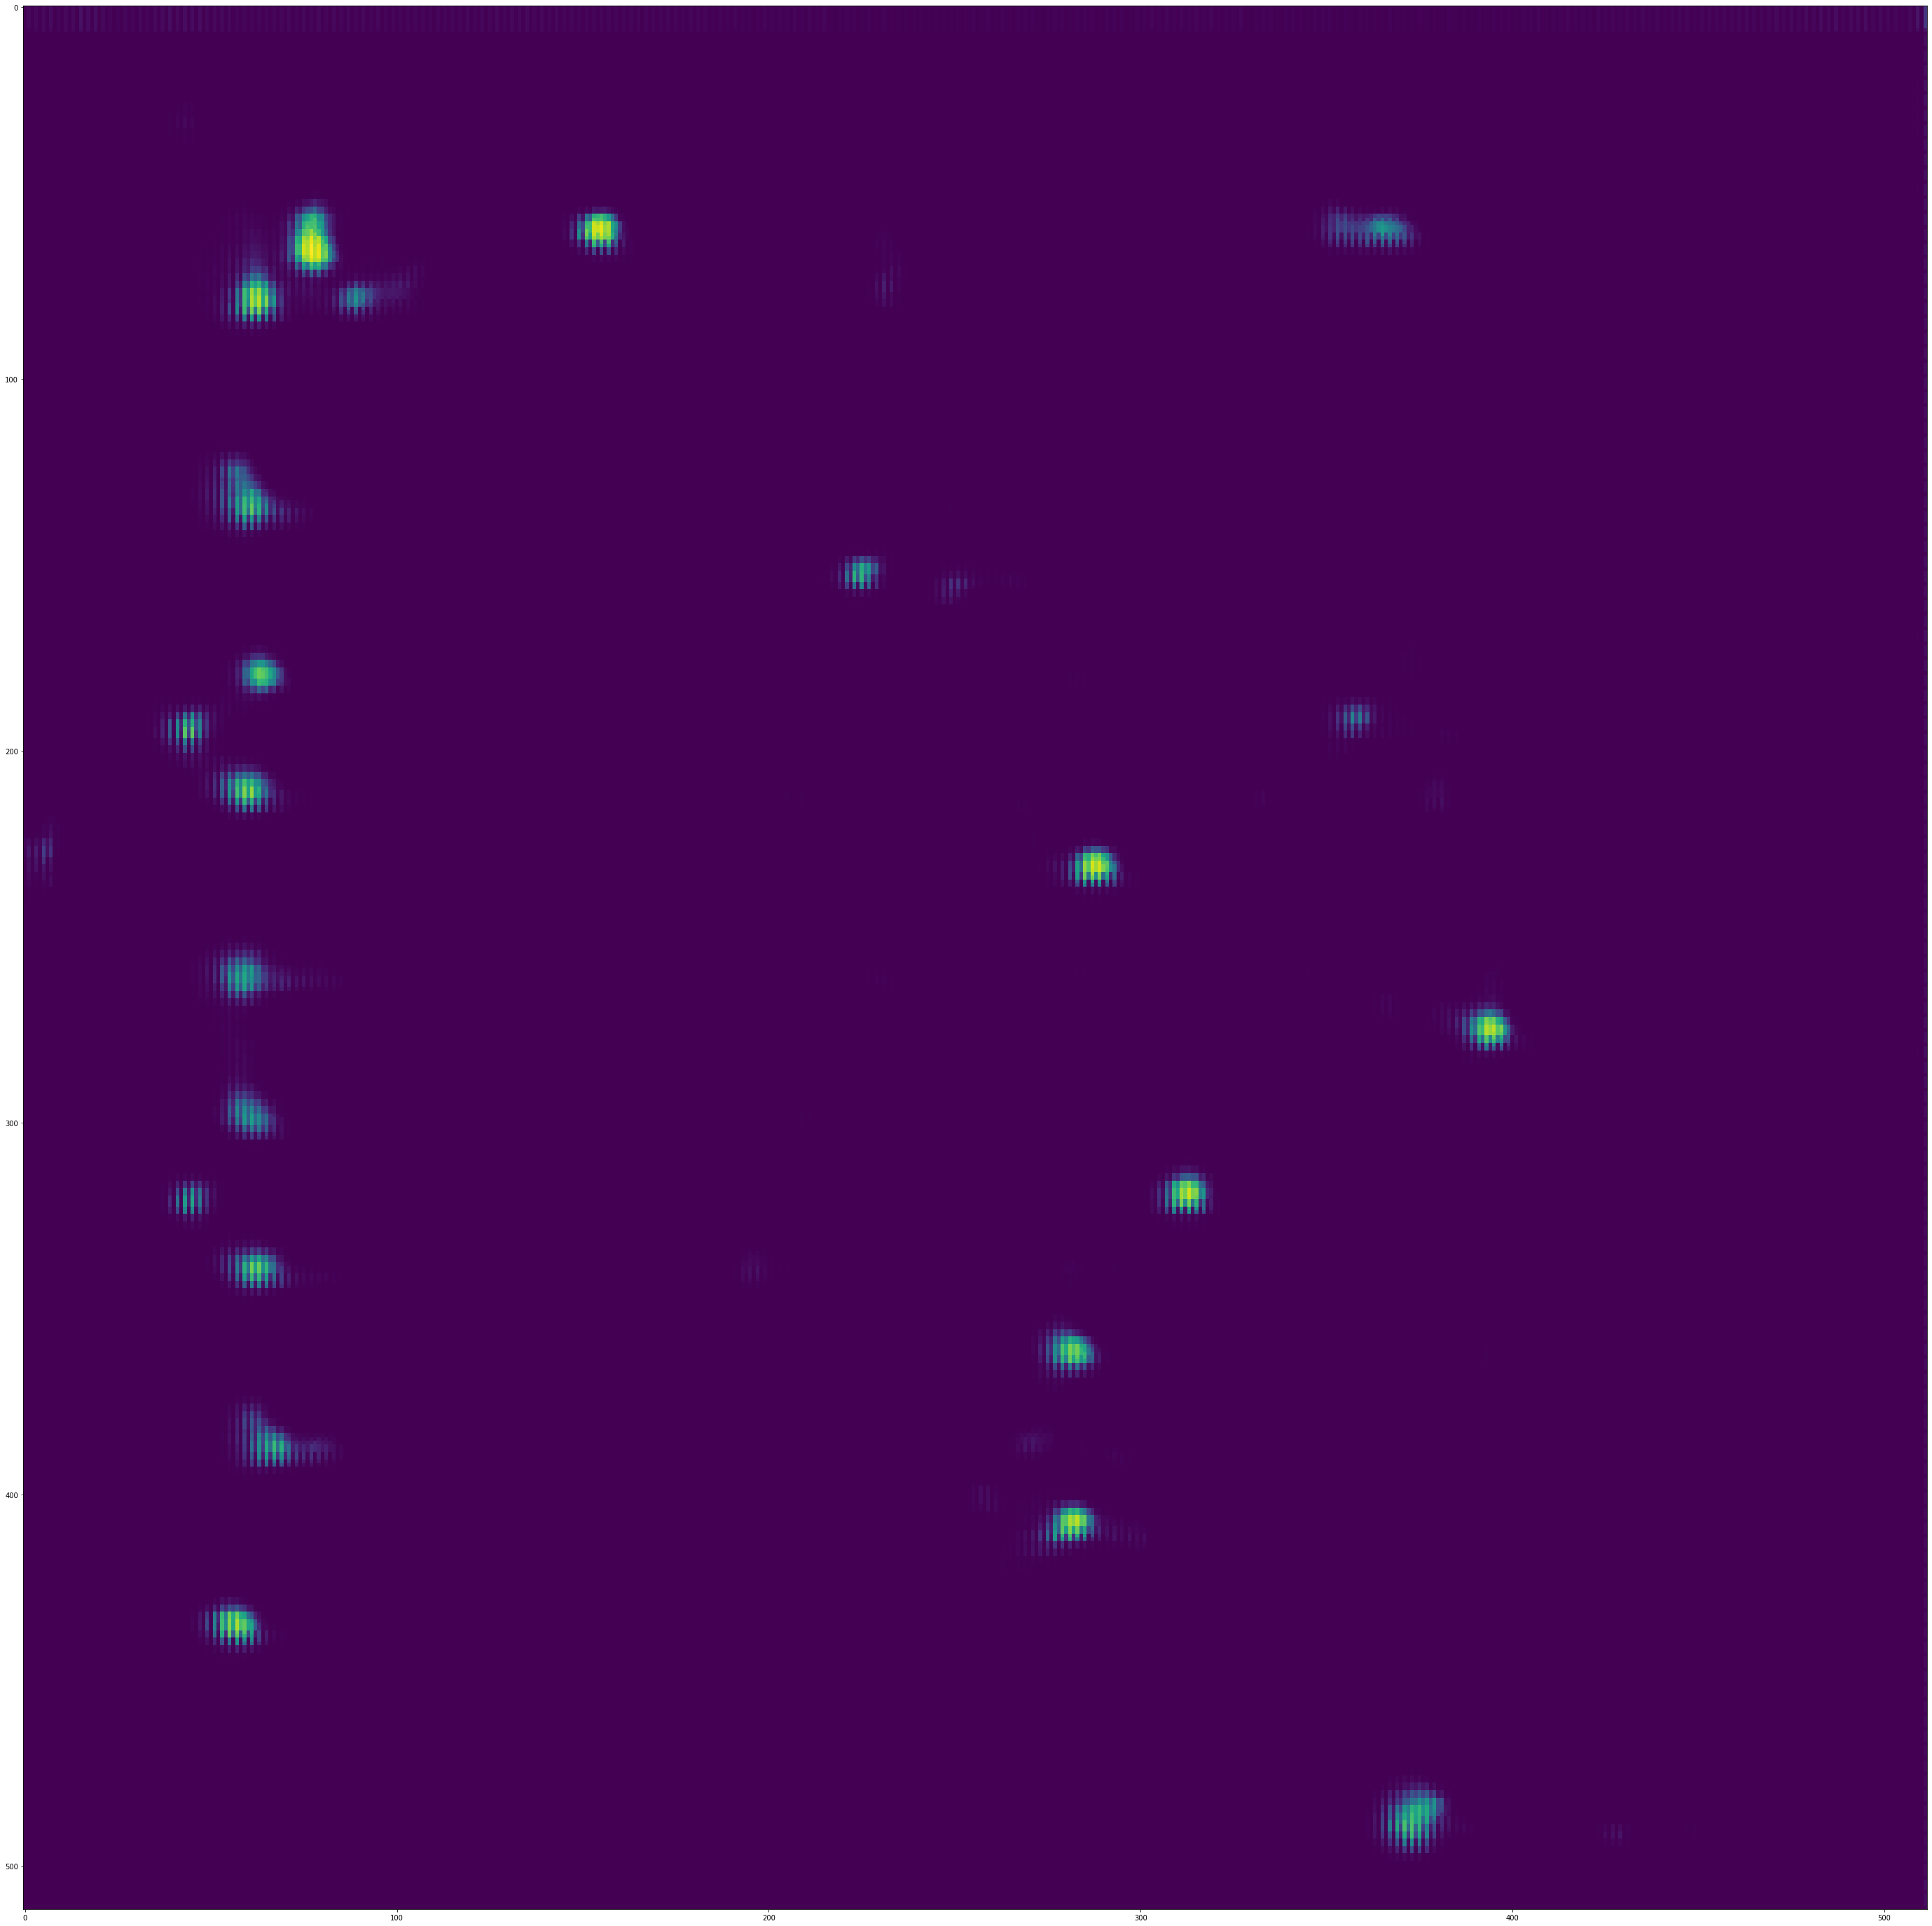

In [365]:
plt.figure(figsize=(50,50))
plt.imshow(shrink[:, :, 2])

In [352]:
#probs = seg_out[0, 0:3, :, :].permute(1,2,0).detach().numpy()**2
probs_c = cleaning_probs(probs, 0.9)
probs_t = threshold(probs_c, 0.3)*1.0
probs_tcleaned = bwClean(probs_t)

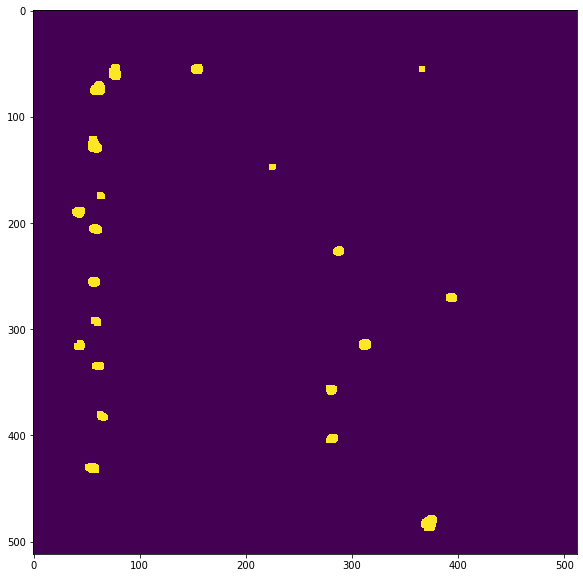

In [353]:
plt.figure(figsize=(20,10))
plt.imshow(probs_tcleaned[:,:,2])

In [206]:
type(probs)

numpy.ndarray

In [162]:
type(t)

numpy.ndarray

In [159]:
probs.shape

(512, 512, 3)

In [160]:
t.shape

(512, 512, 3)

In [156]:
t.shape

(512, 512, 3)

In [155]:
tc = cv2.GaussianBlur(probs, (5,5), 0)

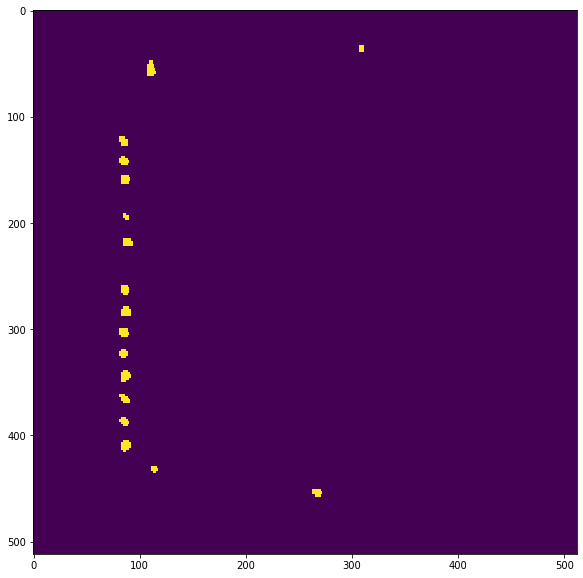

In [132]:
plt.figure(figsize=(20,10))
plt.imshow(tc)

In [82]:
import numpy as np
import cv2
from scipy.ndimage import label

# debug only
import matplotlib.pyplot as mpl # debug only
from imageio import imsave

def threshold(probs: np.ndarray, threshold: float=-1) -> np.ndarray:
    """
    Computes the binary mask of the detected Page from the probabilities output by network.
    :param probs: array in range [0, 1] of shape HxWx2
    :param threshold: threshold between [0 and 1], if negative Otsu's adaptive threshold will be used
    :return: binary mask
    """

    if threshold < 0:  # Otsu's thresholding
        probs = np.uint8(probs * 255)
        probsG = cv2.GaussianBlur(probs, (15, 15), 0)

        thresh_val, bin_img = cv2.threshold(probs, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask = bin_img
    else:
        mask = probs > threshold

    return mask


def bwClean(mask: np.ndarray, size: int=5):
    
    ksize = (size, size)

    bwC = mask.astype(np.uint8, copy=True)

    bwC = cv2.morphologyEx(bwC, cv2.MORPH_OPEN, kernel=np.ones(ksize))
    bwC = cv2.morphologyEx(bwC, cv2.MORPH_CLOSE, kernel=np.ones(ksize))

    return bwC
def cleaning_binary(mask: np.ndarray, kernel_size: int=5) -> np.ndarray:
    """
    Uses mathematical morphology to clean and remove small elements from binary images.
    :param mask: the binary image to clean
    :param kernel_size: size of the kernel
    :return: the cleaned mask
    """

    ksize_open = (kernel_size, kernel_size)
    ksize_close = (kernel_size, kernel_size)
    mask = cv2.morphologyEx((mask.astype(np.uint8, copy=False) * 255), cv2.MORPH_OPEN, kernel=np.ones(ksize_open))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones(ksize_close))
    return mask / 255


def hysteresis_thresholding(probs: np.array, low_threshold: float, high_threshold: float,
                            candidates_mask: np.ndarray=None) -> np.ndarray:
    low_mask = probs > low_threshold
    if candidates_mask is not None:
        low_mask = candidates_mask & low_mask
    # Connected components extraction
    label_components, count = label(low_mask, np.ones((3, 3)))
    # Keep components with high threshold elements
    good_labels = np.unique(label_components[low_mask & (probs > high_threshold)])
    label_masks = np.zeros((count + 1,), bool)
    label_masks[good_labels] = 1
    return label_masks[label_components]


def cleaning_probs(probs: np.ndarray, sigma: float) -> np.ndarray:
    # Smooth
    if sigma > 0.:
        return cv2.GaussianBlur(probs, (int(3*sigma)*2+1, int(3*sigma)*2+1), sigma)
    elif sigma == 0.:
        return cv2.fastNlMeansDenoising((probs*255).astype(np.uint8), h=20)/255
    else:  # Negative sigma, do not do anything
        return probs

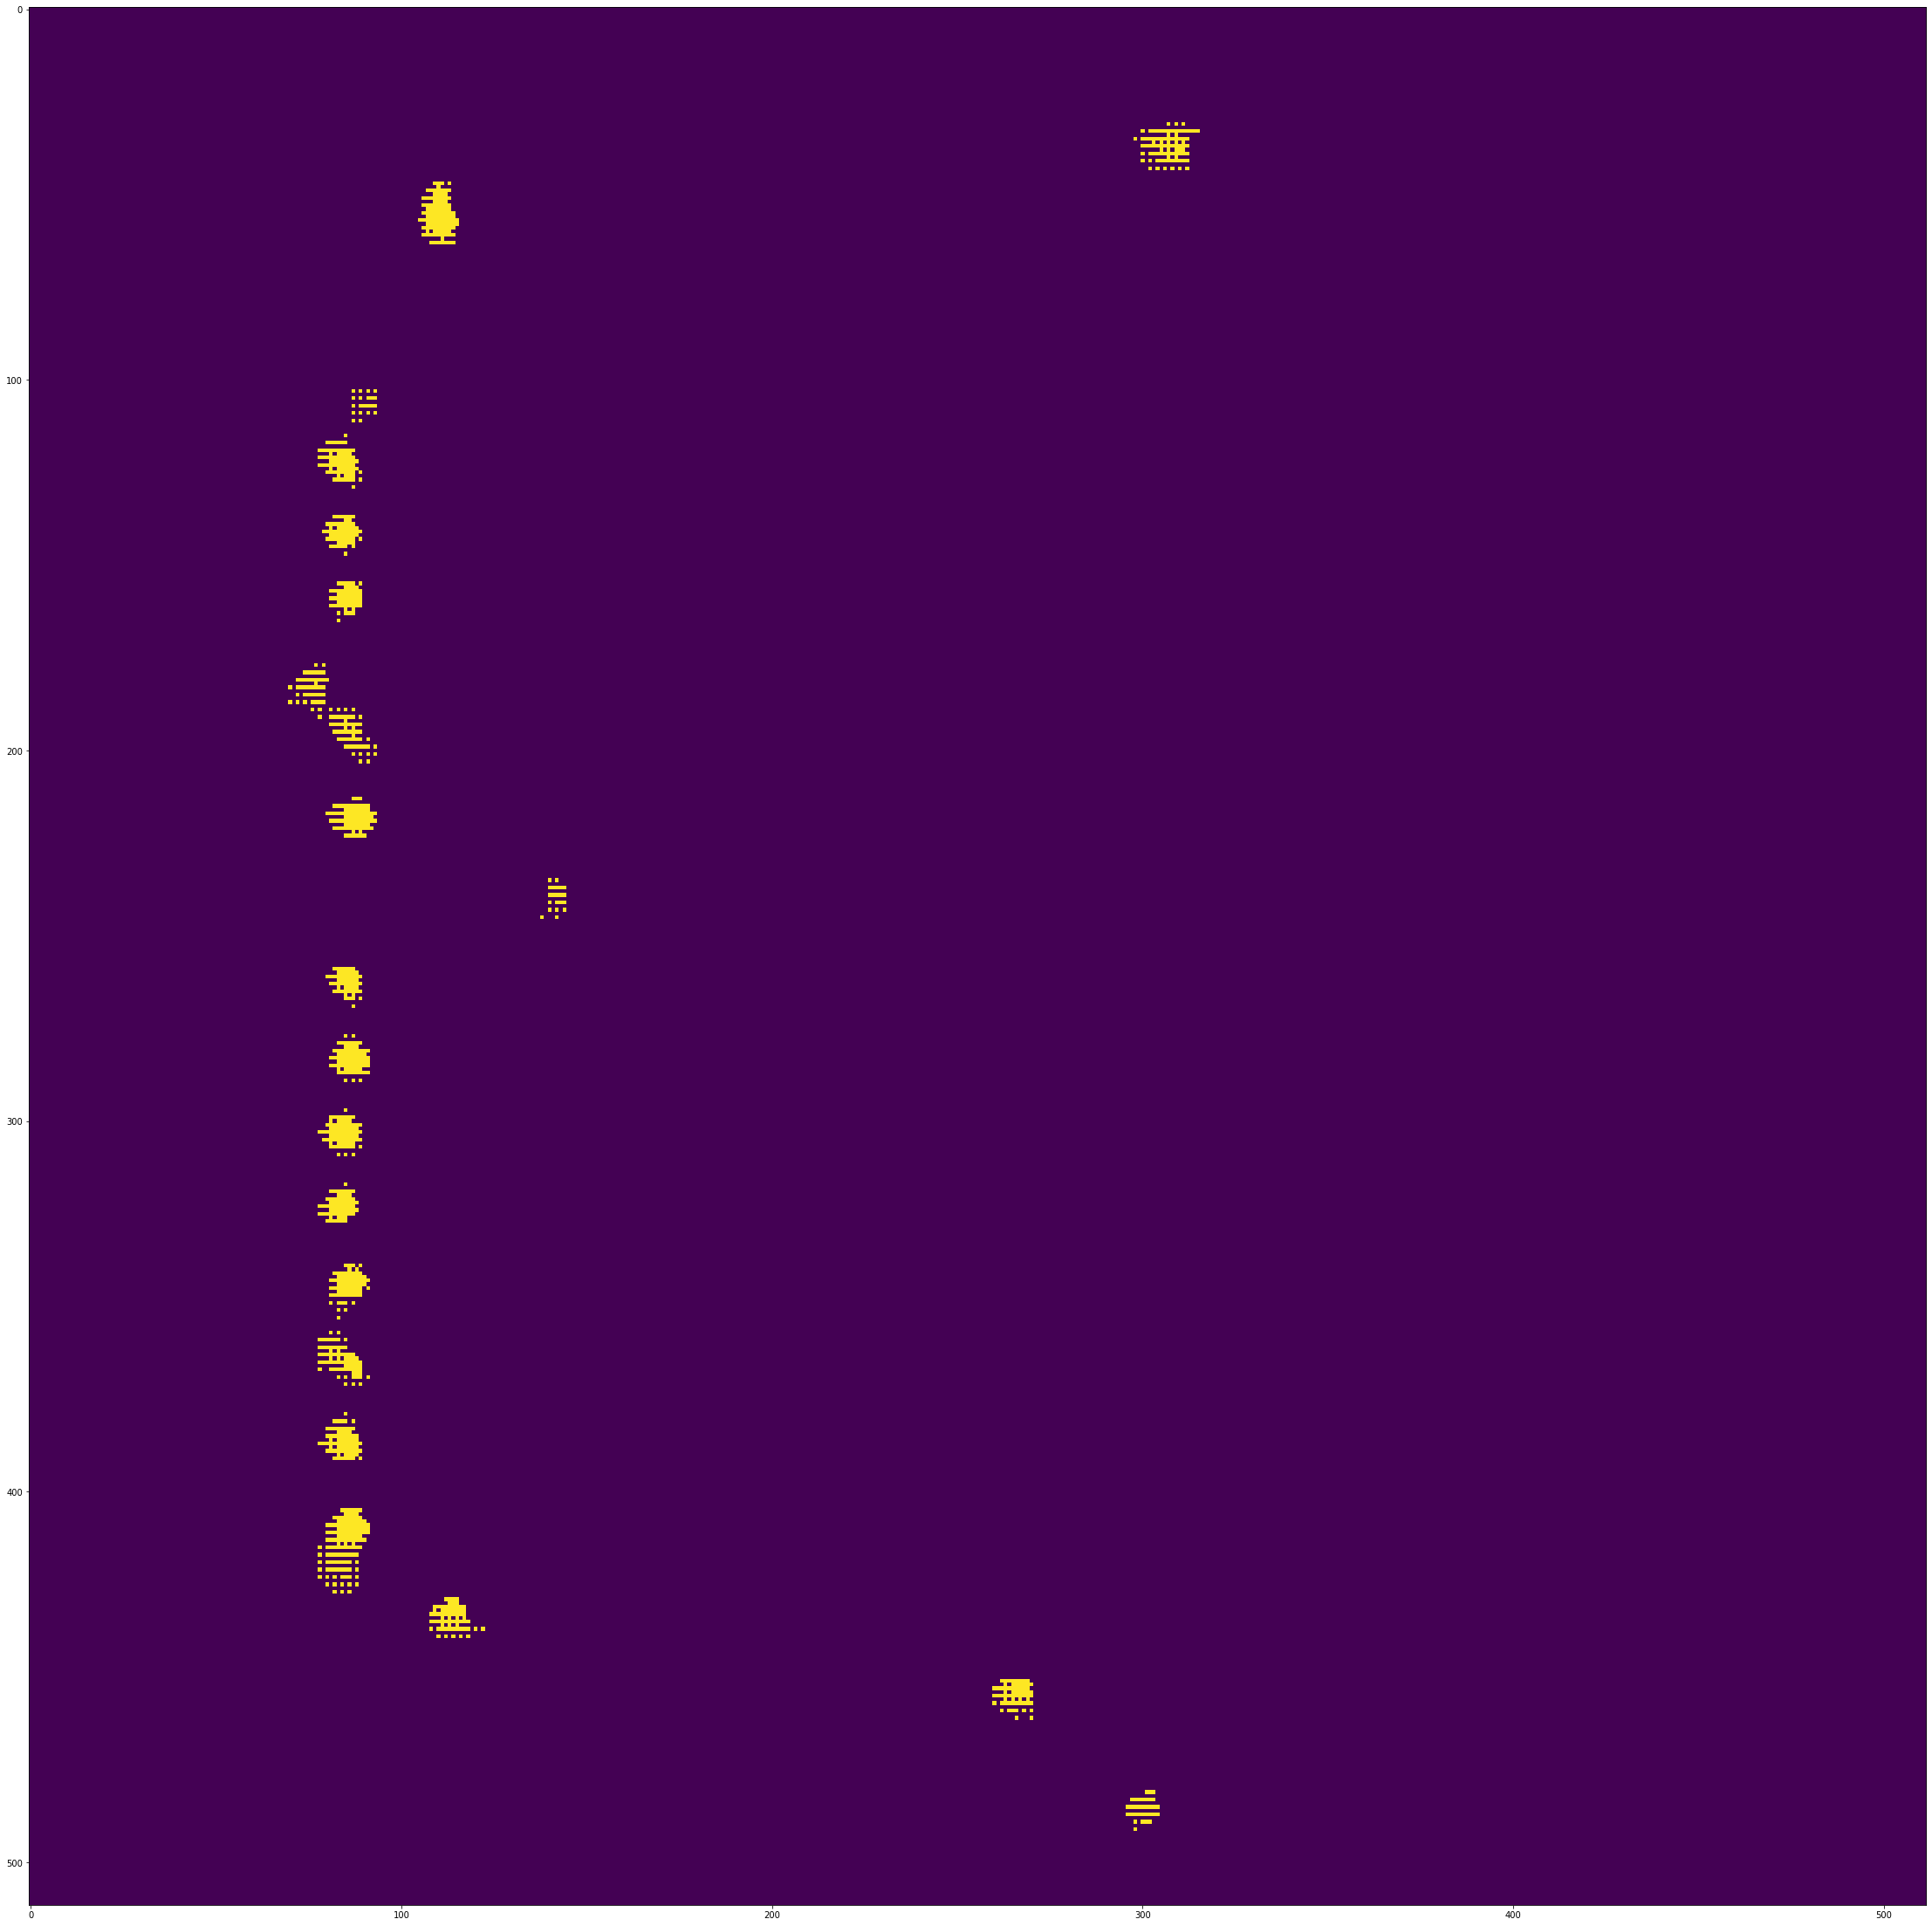

In [80]:
plt.figure(figsize=(30,30))
plt.imshow(image_np[:,:,2]>0.8)